In [ ]:
from google.colab import drive
drive.mount("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
import os
import shutil

# Define the path to the root directory
root_dir = '/content/MyDrive/MyDrive/Final year project/Project /data'

# Traverse the directory to move images
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    if os.path.isdir(folder_path):
        # Check if this folder contains only subfolders
        subdirs = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]

        if subdirs:
            for subdir in subdirs:
                subdir_path = os.path.join(folder_path, subdir)

                # Move all images from subdir to the parent folder
                for file_name in os.listdir(subdir_path):
                    file_path = os.path.join(subdir_path, file_name)
                    if os.path.isfile(file_path):
                        shutil.move(file_path, folder_path)

                # Remove the empty subfolder
                os.rmdir(subdir_path)

print("Images have been moved, and empty subfolders removed.")


Images have been moved, and empty subfolders removed.


In [ ]:
def create_image_dataframe():
    base_dir = "/content/MyDrive/MyDrive/Final year project/Project /data"

    # Categories based on folder names
    categories = ['Covid', 'Tuberculosis','Pneumonia', 'Normal']
    # List to store the data
    data = []

    # Loop through each category directory
    for category in categories:
        category_path = os.path.join(base_dir, category)
        if os.path.exists(category_path):
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                if os.path.isfile(img_path):
                    data.append({'Image_Path': img_path, 'Category': category})

    # Create a DataFrame
    df = pd.DataFrame(data)
    return df

In [ ]:
df_images = create_image_dataframe()
df_images.head()

,Image_Path,Category
0,/content/MyDrive/MyDrive/Final year project/Pr...,Covid
1,/content/MyDrive/MyDrive/Final year project/Pr...,Covid
2,/content/MyDrive/MyDrive/Final year project/Pr...,Covid
3,/content/MyDrive/MyDrive/Final year project/Pr...,Covid
4,/content/MyDrive/MyDrive/Final year project/Pr...,Covid


In [ ]:
 df_images.to_csv('images_df.csv', index=False)

In [ ]:
df = pd.read_csv('images_df.csv')

In [ ]:
df["Category"].unique()

array(['Covid', 'Tuberculosis', 'Pneumonia', 'Normal'], dtype=object)

In [ ]:
df.Category.value_counts()

,count
Category,
Covid,3616
Normal,3524
Tuberculosis,3500
Pneumonia,1624


In [ ]:
covid = df[df.Category == 'Covid'].sample(n=3500, random_state=1)
normal = df[df.Category == 'Normal'].sample(n=3500, random_state=1)
tuberculosis = df[df.Category == 'Tuberculosis'].sample(n=3500, random_state=1)
pneumonia = df[df.Category == 'Pneumonia']

In [ ]:
sample_df = pd.concat([covid, normal, tuberculosis, pneumonia])

In [ ]:
sample_df = sample_df.sample(frac=1).reset_index(drop=True)

In [ ]:
sample_df.Category.value_counts()

,count
Category,
Tuberculosis,3500
Normal,3500
Covid,3500
Pneumonia,1624


# Image PreProcessing

In [ ]:
# necessary libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [ ]:
# # data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
    validation_split=0.1)

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=sample_df,
#     directory=images_dir,
    x_col='Image_Path',
    y_col='Category',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    seed = 42)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=sample_df,
#     directory=images_dir,
    x_col='Image_Path',
    y_col='Category',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    seed = 42)

Found 10912 validated image filenames belonging to 4 classes.
Found 1212 validated image filenames belonging to 4 classes.


In [ ]:
#the CNN configuration
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(32, activation='relu'),
#     Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,384,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,395,284 (5.32 MB)

 Trainable params: 1,395,284 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#compiling the model before training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the custom model

In [ ]:
#training the model
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 97s 71ms/step - accuracy: 0.9803 - loss: 0.0559 - val_accuracy: 0.9150 - val_loss: 0.3089
Epoch 2/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 70ms/step - accuracy: 0.9845 - loss: 0.0488 - val_accuracy: 0.9142 - val_loss: 0.3411
Epoch 3/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 138s 67ms/step - accuracy: 0.9850 - loss: 0.0453 - val_accuracy: 0.9035 - val_loss: 0.4507
Epoch 4/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 141s 66ms/step - accuracy: 0.9855 - loss: 0.0457 - val_accuracy: 0.9134 - val_loss: 0.4058
Epoch 5/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 65ms/step - accuracy: 0.9924 - loss: 0.0226 - val_accuracy: 0.9142 - val_loss: 0.4860
Epoch 6/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 144s 67ms/step - accuracy: 0.9921 - loss: 0.0252 - val_accuracy: 0.9266 - val_loss: 0.4101
Epoch 7/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 140s 66ms/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9117 - val_loss: 0.5029
Epoch 8/10
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 91s 66ms/step - accuracy: 0.

# Model Evaluation

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {int(val_accuracy* 100)}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9388 - loss: 0.4270
Validation loss: 0.4667111039161682
Validation accuracy: 92


In [ ]:
def plot_history(history):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Adjusting the accuracy data to start from zero
    train_accuracy = np.insert(history.history['accuracy'], 0, 0)
    val_accuracy = np.insert(history.history['val_accuracy'], 0, 0)

    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim(bottom=0)

    # Plotting training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim(bottom=0)

    plt.show()

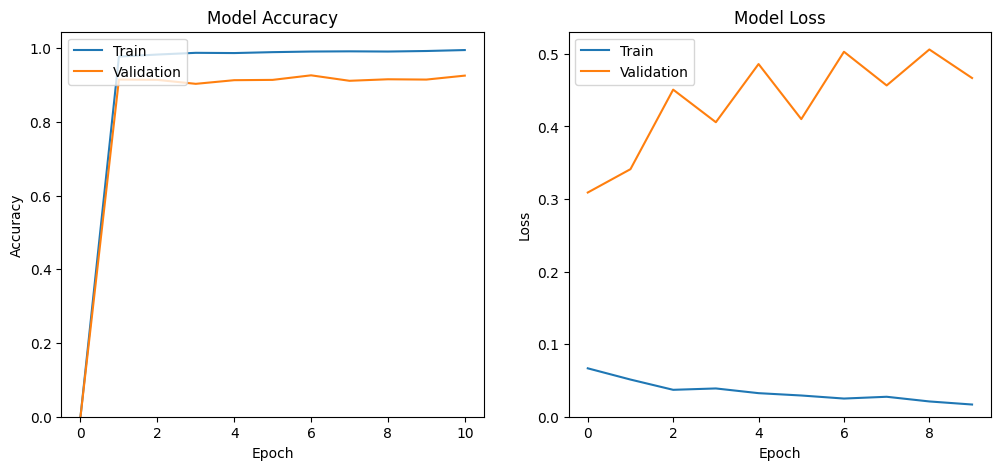

In [ ]:
plot_history(history)

In [ ]:
# Save the model
model.save('base_model.h5')

# Informational message
print("Model saved successfully.")

Model saved successfully.


# Pretrained Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers

In [ ]:
# Load the base INCEPTION v3 model, excluding its top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False


# # Flatten the output layer to 1 dimension
# x = base_model.output

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)

# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# # Add a final sigmoid layer with 1 node for classification output
# x = layers.Dense(1, activation='sigmoid')(x)

# model = tf.keras.models.Model(base_model.input, x)





# # Add custom layers on top for our specific classification task
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')
# predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# new_model = Model(inputs=base_model.input, outputs=predictions)

# # Compile the model
# new_model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Early stopping callback to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x)

new_model = Model(base_model.input, x)

new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history_new = new_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator)

Epoch 1/5
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 125s 86ms/step - accuracy: 0.7113 - loss: 1.0996 - val_accuracy: 0.9142 - val_loss: 0.2483
Epoch 2/5
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 107s 78ms/step - accuracy: 0.8283 - loss: 0.4364 - val_accuracy: 0.9224 - val_loss: 0.2199
Epoch 3/5
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 108s 79ms/step - accuracy: 0.8448 - loss: 0.3841 - val_accuracy: 0.9455 - val_loss: 0.1711
Epoch 4/5
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 145s 81ms/step - accuracy: 0.8870 - loss: 0.3110 - val_accuracy: 0.9464 - val_loss: 0.1447
Epoch 5/5
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 107s 78ms/step - accuracy: 0.8813 - loss: 0.3078 - val_accuracy: 0.9365 - val_loss: 0.1663


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = new_model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {int(val_accuracy* 100)}")

152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.9411 - loss: 0.1594
Validation loss: 0.16625358164310455
Validation accuracy: 93


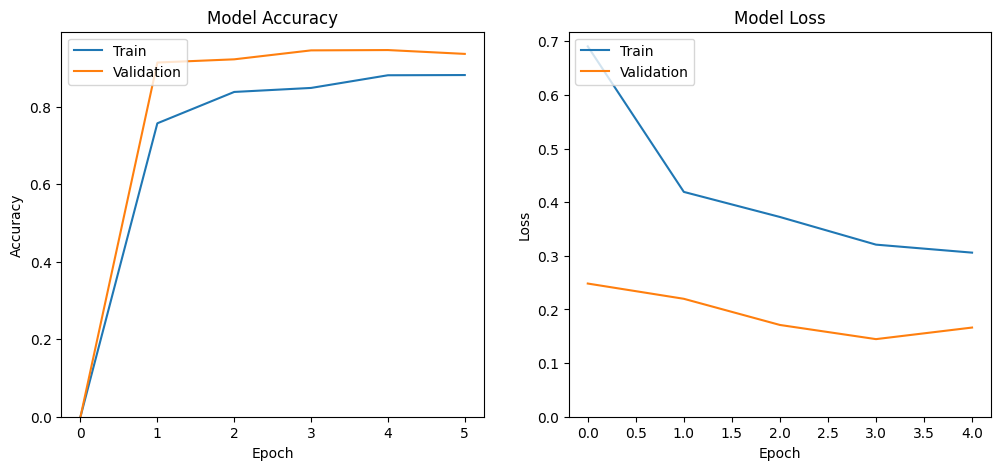

In [ ]:
plot_history(history_new)

In [ ]:
new_model.save('pretrained_model.h5')

# Overall Evaluation

In [ ]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=sample_df,
#     directory=images_dir,
    x_col='Image_Path',
    y_col='Category',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='training',
    seed = 42,
    shuffle=False)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=sample_df,
#     directory=images_dir,
    x_col='Image_Path',
    y_col='Category',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    subset='validation',
    seed = 42,
    shuffle=False)

Found 10912 validated image filenames belonging to 4 classes.
Found 1212 validated image filenames belonging to 4 classes.


In [ ]:
#loading the trained models

pretrained_model = tf.keras.models.load_model('pretrained_model.h5')
base_model = tf.keras.models.load_model('base_model.h5')

In [ ]:
# Function to predict and calculate metrics
def calculate_metrics(model, generator):
    generator.reset()
    pred_probs = model.predict(generator)
    predictions = np.argmax(pred_probs, axis=1)

    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    accuracy = accuracy_score(true_classes, predictions)
    f1 = f1_score(true_classes, predictions, average='macro')
    precision = precision_score(true_classes, predictions, average='macro')
    recall = recall_score(true_classes, predictions, average='macro')
    auc = roc_auc_score(tf.keras.utils.to_categorical(true_classes, num_classes=len(class_labels)), pred_probs, multi_class='ovr')
    conf_matrix = confusion_matrix(true_classes, predictions)

    return accuracy, f1, precision, recall, auc, conf_matrix

In [ ]:
# Evaluate training data
train_metrics_pretrained = calculate_metrics(pretrained_model, train_generator)
train_metrics_base = calculate_metrics(base_model, train_generator)

# Evaluate validation data
validation_metrics_pretrained = calculate_metrics(pretrained_model, validation_generator)
validation_metrics_base = calculate_metrics(base_model, validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1364/1364 ━━━━━━━━━━━━━━━━━━━━ 94s 67ms/step
1364/1364 ━━━━━━━━━━━━━━━━━━━━ 92s 67ms/step
  2/152 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step


In [ ]:
metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'AUC', 'Confusion Matrix'],
        'Pretrained Training': train_metrics_pretrained,
        'Base Training': train_metrics_base,
        'Pretrained Validation': validation_metrics_pretrained,
        'Base Validation': validation_metrics_base,
    })

In [ ]:
metrics_df

,Metric,Pretrained Training,Base Training,Pretrained Validation,Base Validation
0,Accuracy,0.955004,0.998167,0.936469,0.925743
1,F1 Score,0.956738,0.998139,0.940472,0.928233
2,Precision,0.961969,0.99796,0.948699,0.924665
3,Recall,0.953212,0.998319,0.935185,0.932995
4,AUC,0.996932,0.999977,0.993941,0.989461
5,Confusion Matrix,"[[3102, 36, 1, 4], [193, 2928, 10, 10], [23, 6...","[[3135, 5, 0, 3], [4, 3131, 5, 1], [1, 0, 1470...","[[348, 7, 0, 2], [28, 328, 1, 2], [4, 7, 142, ...","[[333, 13, 2, 9], [30, 312, 10, 7], [1, 1, 149..."
